# Handwritten Digits - MNIST GAN With Improved Training

Make Your First GAN With MindSpore, 2022

In [1]:
# import libraries

import mindspore
import mindspore.nn as nn

import pandas, numpy, random
import matplotlib.pyplot as plt

## Dataset Class

In [2]:
# dataset class

class MnistDataset:
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = numpy.zeros((10), dtype=numpy.float32)
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = numpy.array(self.data_df.iloc[index,1:].values, dtype=numpy.float32) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')


In [3]:
# load data

mnist_dataset = MnistDataset('./dataset/mnist/mnist_train.csv')

train_dataset = mindspore.dataset.GeneratorDataset(mnist_dataset, ['label', 'image', 'target']).batch(1)

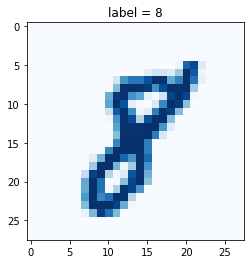

In [4]:
# check data contains images

mnist_dataset.plot_image(17)

## Data Functions

In [5]:
# functions to generate random data

def generate_random_image(*size):
    random_data = mindspore.Tensor(numpy.random.rand(*size), mindspore.float32)
    return random_data


def generate_random_seed(*size):
    random_data = mindspore.Tensor(numpy.random.randn(*size), mindspore.float32)
    return random_data

## Discriminator Network

In [6]:
# discriminator class

class Discriminator(nn.Cell):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            nn.Dense(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm((200,)),

            nn.Dense(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss(reduction='mean')

        # create optimizer
        self.optimizer = nn.Adam(self.model.trainable_params(), learning_rate=0.0001)
        
        self.model_with_loss = nn.WithLossCell(self.model, self.loss_function)
        self.model_train = nn.TrainOneStepCell(self.model_with_loss, self.optimizer)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
    
    def construct(self, inputs):
        if inputs.ndim == 1:
            inputs = mindspore.ops.ExpandDims()(inputs, 0)
            return self.model(inputs).squeeze(0)
        else:    
            return self.model(inputs)
    
    def train(self, inputs, targets):
        # train one step
        loss = self.model_train(inputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.asnumpy().item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


## Test Discriminator

In [7]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()

label_true = mindspore.Tensor([[1.0]], mindspore.float32)
label_false = mindspore.Tensor([[0.0]], mindspore.float32)

for label, image_data_tensor, target_tensor in train_dataset:
    # real data
    D.train(image_data_tensor, label_true)
    # fake data
    D.train(generate_random_image(1, 784), label_false)


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 5min 11s, sys: 1min 40s, total: 6min 52s
Wall time: 4min 45s


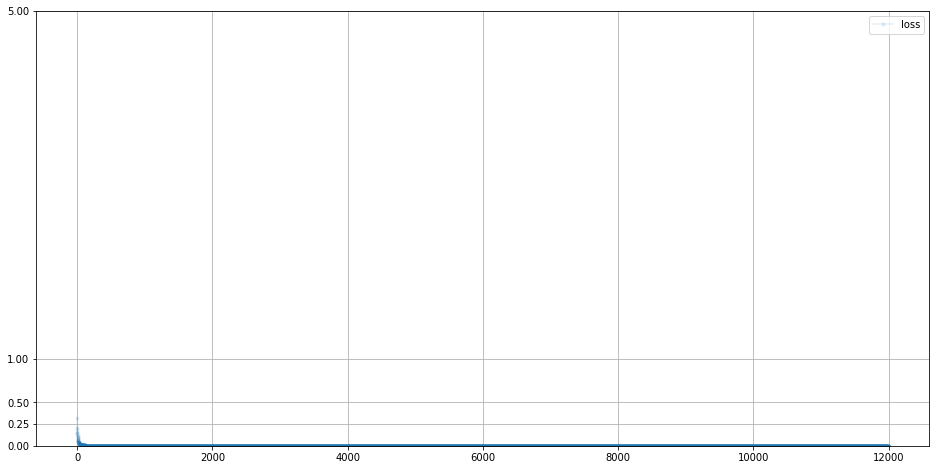

In [8]:
# plot discriminator loss

D.plot_progress()

In [9]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = mindspore.Tensor(mnist_dataset[random.randint(0,60000)][1], mindspore.float32)
  print( D.construct( image_data_tensor ).asnumpy().item() )

for i in range(4):
  print( D.construct( generate_random_image(784) ).asnumpy().item() )

1.0
1.0
1.0
1.0
6.72133225812499e-12
6.678038764335037e-12
6.485824464302903e-12
7.052835745979813e-12


## Generator Network

In [10]:
# generator class

class Generator(nn.Cell):
    
    def __init__(self, D_with_loss):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            nn.Dense(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm((200,)),

            nn.Dense(200, 784),
            nn.Sigmoid()
        )
        
        self.loss_fn = D_with_loss
        
        # create optimiser, simple stochastic gradient descent
        self.optimizer = nn.Adam(self.model.trainable_params(), learning_rate=0.0001)
        
        self.model_train = mindspore.build_train_network(self.model, self.optimizer, loss_fn=self.loss_fn)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
    
    def construct(self, inputs):        
        # simply run model
        if inputs.ndim == 1:
            inputs = mindspore.ops.ExpandDims()(inputs, 0)
            return self.model(inputs).squeeze(0)
        else:    
            return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate error
        loss = self.model_train(inputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.asnumpy().item())

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


## Test Generator Output

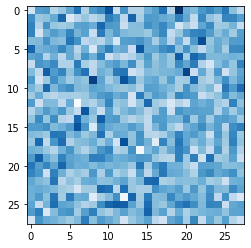

In [11]:
# check the generator output is of the right type and shape

G = Generator(D.model_with_loss)

output = G.construct(generate_random_seed(100))

img = output.asnumpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [12]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator(D.model_with_loss)

label_true = mindspore.Tensor([[1.0]], mindspore.float32)
label_false = mindspore.Tensor([[0.0]], mindspore.float32)

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for label, image_data_tensor, target_tensor in train_dataset:
    # train discriminator on true
    D.train(image_data_tensor, label_true)
    
    # train discriminator on false
    D.train(G.construct(generate_random_seed(100)).reshape(1, -1), label_false)
    
    # train generator
    G.train(generate_random_seed(1, 100), label_true)


epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 42min 1s, sys: 12min 55s, total: 54min 57s
Wall time: 41min 58s


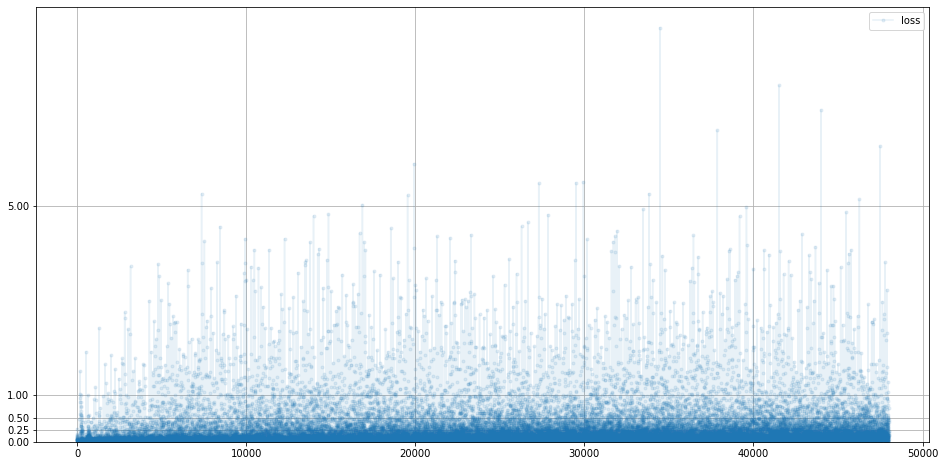

In [13]:
# plot discriminator error

D.plot_progress()

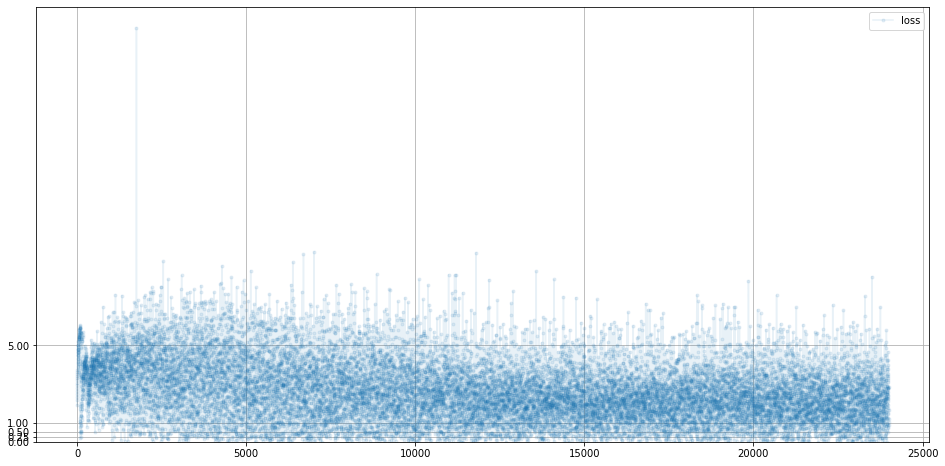

In [14]:
# plot generator error

G.plot_progress()

## Run Generator

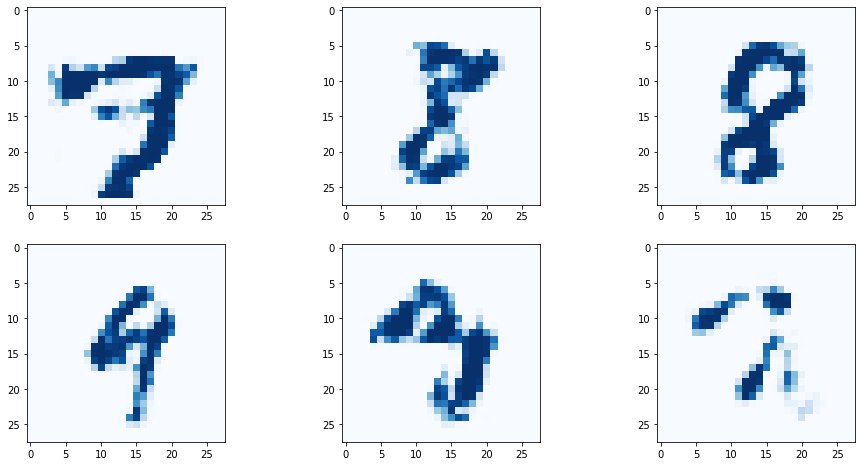

In [16]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.construct(generate_random_seed(100))
        img = output.asnumpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
